In [1]:
import sys
import numpy as np
np.random.seed(0)
import torch
import pylab
from sklearn.metrics import confusion_matrix
import itertools
from debug_visualisation import plot_confusion_matrix

# Main code for Concrete Dropout

In [2]:
import keras.backend as K
from keras import initializers
from keras.engine import InputSpec
from keras.layers import Dense, Lambda, Wrapper, Concatenate


class ConcreteDropout(Wrapper):
    """This wrapper allows to learn the dropout probability for any given input layer.
    ```python
        # as the first layer in a model
        model = Sequential()
        model.add(ConcreteDropout(Dense(8), input_shape=(16)))
        # now model.output_shape == (None, 8)
        # subsequent layers: no need for input_shape
        model.add(ConcreteDropout(Dense(32)))
        # now model.output_shape == (None, 32)
    ```
    `ConcreteDropout` can be used with arbitrary layers, not just `Dense`,
    for instance with a `Conv2D` layer:
    ```python
        model = Sequential()
        model.add(ConcreteDropout(Conv2D(64, (3, 3)),
                                  input_shape=(299, 299, 3)))
    ```
    # Arguments
        layer: a layer instance.
        weight_regularizer:
            A positive number which satisfies
                $weight_regularizer = l**2 / (\tau * N)$
            with prior lengthscale l, model precision $\tau$ (inverse observation noise),
            and N the number of instances in the dataset.
            Note that kernel_regularizer is not needed.
        dropout_regularizer:
            A positive number which satisfies
                $dropout_regularizer = 2 / (\tau * N)$
            with model precision $\tau$ (inverse observation noise) and N the number of
            instances in the dataset.
            Note the relation between dropout_regularizer and weight_regularizer:
                $weight_regularizer / dropout_regularizer = l**2 / 2$
            with prior lengthscale l. Note also that the factor of two should be
            ignored for cross-entropy loss, and used only for the eculedian loss.
    """

    def __init__(self, layer, weight_regularizer=1e-6, dropout_regularizer=1e-5,
                 init_min=0.1, init_max=0.1, is_mc_dropout=True, **kwargs):
        assert 'kernel_regularizer' not in kwargs
        super(ConcreteDropout, self).__init__(layer, **kwargs)
        self.weight_regularizer = weight_regularizer
        self.dropout_regularizer = dropout_regularizer
        self.is_mc_dropout = is_mc_dropout
        self.supports_masking = True
        self.p_logit = None
        self.p = None
        self.init_min = np.log(init_min) - np.log(1. - init_min)
        self.init_max = np.log(init_max) - np.log(1. - init_max)

    def build(self, input_shape=None):
        self.input_spec = InputSpec(shape=input_shape)
        if not self.layer.built:
            self.layer.build(input_shape)
            self.layer.built = True
        super(ConcreteDropout, self).build()  # this is very weird.. we must call super before we add new losses

        # initialise p
        self.p_logit = self.layer.add_weight(name='p_logit',
                                            shape=(1,),
                                            initializer=initializers.RandomUniform(self.init_min, self.init_max),
                                            trainable=True)
        self.p = K.sigmoid(self.p_logit[0])

        # initialise regulariser / prior KL term
        input_dim = np.prod(input_shape[1:])  # we drop only last dim
        weight = self.layer.kernel
        kernel_regularizer = self.weight_regularizer * K.sum(K.square(weight)) / (1. - self.p)
        dropout_regularizer = self.p * K.log(self.p)
        dropout_regularizer += (1. - self.p) * K.log(1. - self.p)
        dropout_regularizer *= self.dropout_regularizer * input_dim
        regularizer = K.sum(kernel_regularizer + dropout_regularizer)
        self.layer.add_loss(regularizer)

    def compute_output_shape(self, input_shape):
        return self.layer.compute_output_shape(input_shape)

    def concrete_dropout(self, x):
        '''
        Concrete dropout - used at training time (gradients can be propagated)
        :param x: input
        :return:  approx. dropped out input
        '''
        eps = K.cast_to_floatx(K.epsilon())
        temp = 0.1

        unif_noise = K.random_uniform(shape=K.shape(x))
        drop_prob = (
            K.log(self.p + eps)
            - K.log(1. - self.p + eps)
            + K.log(unif_noise + eps)
            - K.log(1. - unif_noise + eps)
        )
        drop_prob = K.sigmoid(drop_prob / temp)
        random_tensor = 1. - drop_prob

        retain_prob = 1. - self.p
        x *= random_tensor
        x /= retain_prob
        return x

    def call(self, inputs, training=None):
        if self.is_mc_dropout:
            return self.layer.call(self.concrete_dropout(inputs))
        else:
            def relaxed_dropped_inputs():
                return self.layer.call(self.concrete_dropout(inputs))
            return K.in_train_phase(relaxed_dropped_inputs,
                                    self.layer.call(inputs),
                                    training=training)

Using TensorFlow backend.


### Plot function to make sure stuff makes sense:

In [3]:
def plot(reps=None,train_loss=None,valid_loss=None,uncertainty=None,val_acc=None, valid_y=None,preds=None):
    
   fig = pylab.figure() 
   _, (ax1, ax2) = pylab.subplots(1, 2,figsize=(15, 5), sharex=False, sharey=False)
   #Plot loss on training and validation set    
   ax1.plot(reps, train_loss, c='r', label='Training')
   ax1.plot(reps, valid_loss, c='g', label='Validation')
   ax1.set_title('Losses')
   ax1.legend()
   #Plot student confusion matrix
   names = ['Slight-Right-Turn','Sharp-Right-Turn','Move-Forward','Slight-Left-Turn']
   cnf_matrix = confusion_matrix(np.argmax(valid_y,axis=-1), preds)  
   pylab.sca(ax2)
   plot_confusion_matrix(cnf_matrix, classes=names,normalize=False,title='Student confusion matrix')
 
   pylab.show()

# Evaluate Concrete Dropout

In [9]:
nb_epochs = [5]
nb_reps = 5
K_test = 10
batch_size = 20
Q = 24
nb_features = 7
l = 1e-4
D = 4
with open('/tmp/bayesian_compression_24sensorsbnnTest/valid_data_24sensors_teacherLabels.pt','rb') as f:
      valid = torch.load(f)
with open('/tmp/bayesian_compression_24sensorsbnnTest/train_data_24sensors_teacherLabels.pt','rb') as f:
      train = torch.load(f)

     
N = train.shape[0]
X_tr = train[:,0:24]
Y_tr = train[:,24:28]
X_v = valid[:,0:24]
Y_v = valid[:,24:28]
   
    
    

### Fit function:

In [10]:
from keras.layers import Input, Dense, Lambda, merge
from keras.models import Model
from keras import backend as K

def fit_model(nb_epoch, X, Y, validation_data=None):
    if K.backend() == 'tensorflow':
        K.clear_session()
    N = X.shape[0]
    wd = l**2. / N
    dd = 2. / N
    inp = Input(shape=(Q,))
    x = inp
    x = ConcreteDropout(Dense(nb_features, activation='relu',name='CD1'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    #x = ConcreteDropout(Dense(nb_features, activation='relu'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    x = ConcreteDropout(Dense(D,activation='sigmoid',name='CD2'), weight_regularizer=wd, dropout_regularizer=dd)(x)
    out = x 
    model = Model(inp, out)
    
    
    model.compile(optimizer='adam', loss='binary_crossentropy')
    assert len(model.layers[1].trainable_weights) == 3  # kernel, bias, and dropout prob
    assert len(model.losses) == 2  # a loss for each Concrete Dropout layer
    if validation_data==None:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0)    
    else:
        hist = model.fit(X, Y, epochs=nb_epoch, batch_size=batch_size, verbose=0, validation_data=validation_data)
    loss = hist.history['loss'][-1]
    return hist,model, -0.5 * loss  # return ELBO up to const.

### Eval function:

In [11]:
def test(Y_true, MC_samples):
    """
    :Y_true: a 2D array of size N x 4
    :MC_samples: a 3D array of size samples K x N x 4
    """
    assert len(MC_samples.shape) == 3
    assert len(Y_true.shape) == 2
    k = MC_samples.shape[0]
    N = Y_true.shape[0]
    #Get probability of each class after MC sampling, so that we can get the mean
    MC_means = np.sum(MC_samples,axis=0)/float(k)
    MC_pred = np.argmax(MC_means,axis=-1)   
    y_pred = np.argmax(Y_true,axis=-1)
    acc = len(np.where(MC_pred==y_pred)[0])/float(N)*100
   
    print("\n ( Micro Averaging ) Accuracy: {}".format(acc))
    
    return acc, MC_means, MC_pred

        

#Run experiment


 ( Micro Averaging ) Accuracy: 67.49672346
Confusion matrix, without normalization
[[ 22  37  63   0]
 [  1 236  48   0]
 [  1  51 257   0]
 [  0  34  13   0]]


<Figure size 432x288 with 0 Axes>

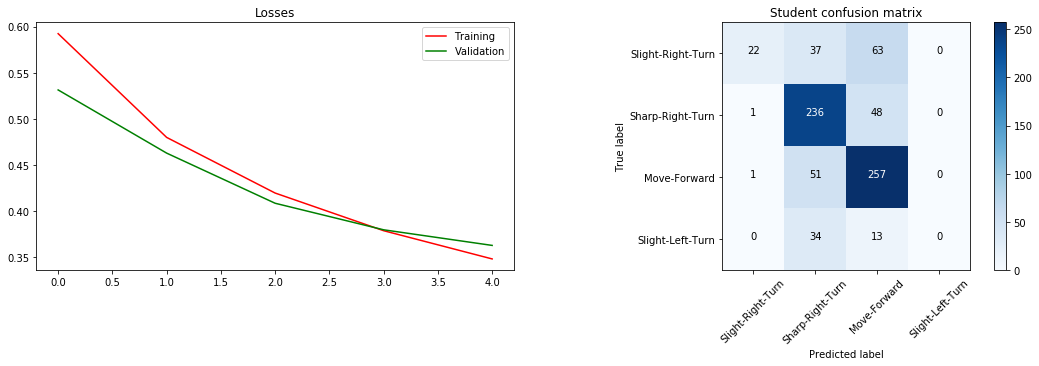


 ( Micro Averaging ) Accuracy: 71.2975098296
saved weigths
71.2975098296
Confusion matrix, without normalization
[[ 52  34  36   0]
 [  4 235  41   5]
 [ 11  60 235   3]
 [  0  18   7  22]]


<Figure size 432x288 with 0 Axes>

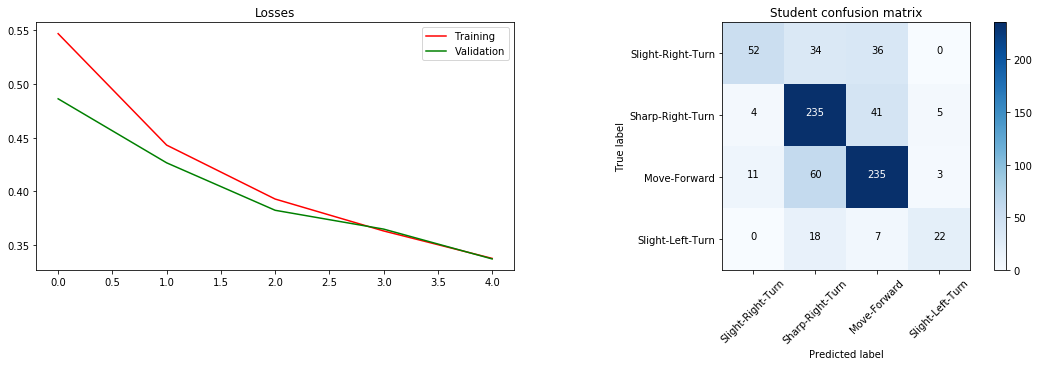


 ( Micro Averaging ) Accuracy: 65.2686762779
Confusion matrix, without normalization
[[  6  79  27  10]
 [  0 235  42   8]
 [  4  69 230   6]
 [  0  15   5  27]]


<Figure size 432x288 with 0 Axes>

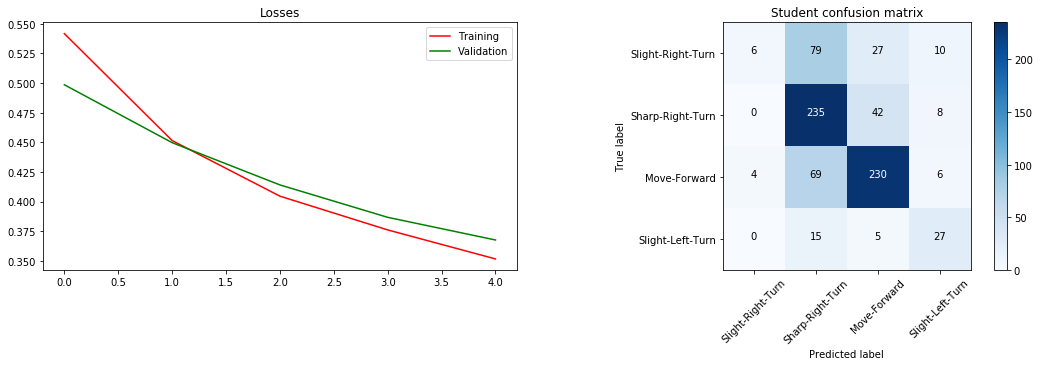


 ( Micro Averaging ) Accuracy: 61.3368283093
Confusion matrix, without normalization
[[  0  55  66   1]
 [  0 230  54   1]
 [  0  74 235   0]
 [  0  16  28   3]]


<Figure size 432x288 with 0 Axes>

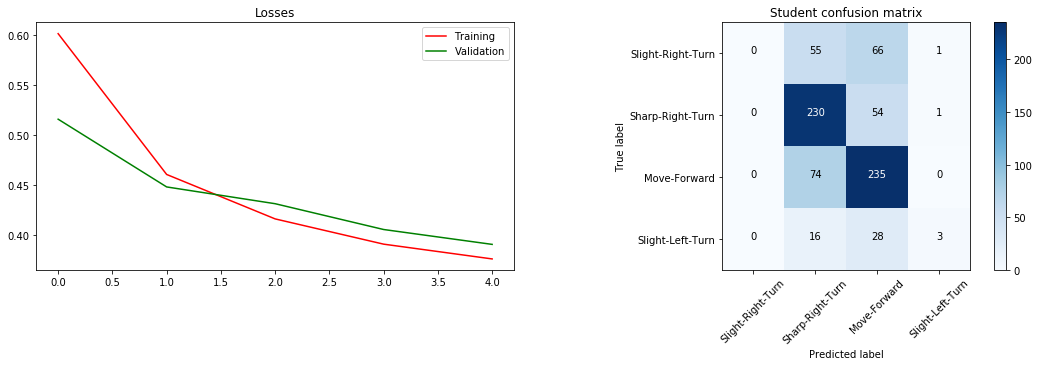


 ( Micro Averaging ) Accuracy: 64.875491481
saved weigths
64.875491481
Confusion matrix, without normalization
[[ 27  50  45   0]
 [  2 200  71  12]
 [  2  56 243   8]
 [  0  14   8  25]]


<Figure size 432x288 with 0 Axes>

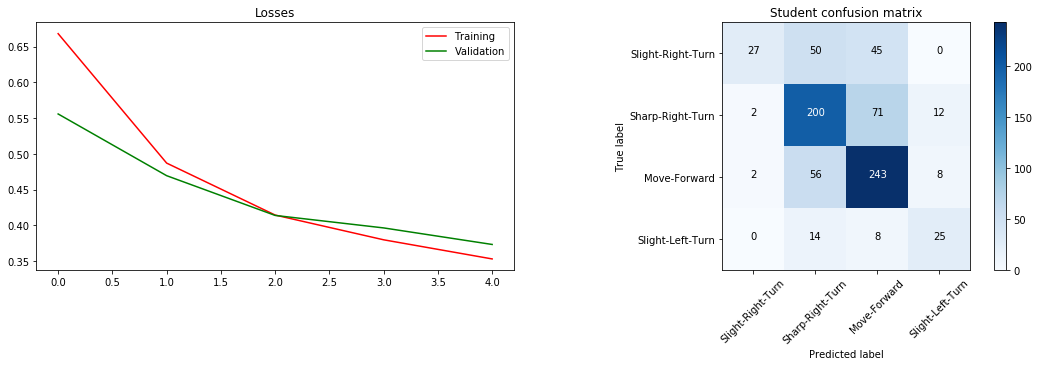

Epoch - Mean accuracy - Accuracy standard deviation - Dropout probabilities per layer   -   Epistemic uncertainty
5 - 66.05504587155963     1.4674217564643162      [0.08198544 0.06645376]  -  0.6664062596003718


In [19]:
results = []

# get results for multiple N
#for N, nb_epoch in zip(Ns, nb_epochs):
for nb_epoch in nb_epochs:
       
    # repeat exp multiple times
    rep_results = []
    for i in xrange(nb_reps):
        X_train, Y_train = X_tr, Y_tr
        X_val, Y_val = X_v, Y_v
        hist, model, ELBO = fit_model(nb_epoch, X_train, Y_train, validation_data=(X_val, Y_val))
        valid_loss_hist = hist.history['val_loss']
        train_loss_hist = hist.history['loss']
       
        MC_samples = np.array([model.predict(X_val) for _ in range(K_test)])
        acc, MC_means, MC_pred = test(Y_val, MC_samples)  
        
        means = np.zeros((Y_val.shape[0],))  
        means_sq = np.zeros((Y_val.shape[0],))  
        means[:] = MC_means[:,0]*0 + MC_means[:,1]*1 + MC_means[:,2]*2 + MC_means[:,3]*3
        means_sq[:] = MC_means[:,0]*(0**2) + MC_means[:,1]*(1**2) + MC_means[:,2]*(2**2) + MC_means[:,3]*(3**2)
        vars = np.zeros((Y_val.shape[0],))  
        vars[:] = means_sq[:] - means[:]**2
        epistemic_uncertainty = vars.mean(0)
        ps = np.array([K.eval(layer.p) for layer in model.layers if hasattr(layer, 'p')])
              
        """
        Save best model weights
        """
        if rep_results!=[]:
            if acc>rep_results[-1][0]:
               model.save_weights('/tmp/compressed_model_weights.h5')
        else:
            model.save_weights('/tmp/compressed_model_weights.h5')

        rep_results += [(acc, ps, epistemic_uncertainty)]
        plot(range(nb_epoch),train_loss=train_loss_hist,valid_loss=valid_loss_hist,valid_y=Y_val,preds=MC_pred)
    
    test_mean = np.mean([r[0] for r in rep_results])
    test_std_err = np.std([r[0] for r in rep_results]) / np.sqrt(nb_reps)
    ps = np.mean([r[1] for r in rep_results], 0)
    epistemic_uncertainty = np.mean([r[2] for r in rep_results])
    print("Epoch - Mean accuracy - Accuracy standard deviation - Dropout probabilities per layer   -   Epistemic uncertainty")
    print nb_epoch, '-', test_mean, '   ', test_std_err, '    ',ps, ' - ', epistemic_uncertainty**0.5
    sys.stdout.flush()
    results += [rep_results]
    



In [ ]:
import pickle
with open('concrete-dropout.pkl', 'wb') as f:
    pickle.dump(results, f)

In [ ]:
# import pickle
# with open('concrete-dropout.pkl', 'rb') as f:
#     results = pickle.load(f)

In [ ]:
best_tests = np.array([[r[0] for r in result] for result in results]).T
best_ps = np.array([[r[1] for r in result] for result in results])
best_epistemic_uncertainty = np.array([[r[2] for r in result] for result in results]).T.squeeze()
print best_tests.mean(0)
print best_ps.mean(1)

In [ ]:
import pylab
%matplotlib inline

pylab.figure(figsize=(3, 3))
pylab.plot(N, np.mean(best_epistemic_uncertainty, 0)**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Epistemic uncertainty (std)')
pylab.xscale('log')
pylab.savefig('epistemic.pdf', bbox_inches='tight')
pylab.show()

pylab.figure(figsize=(3, 3))
predictive = np.mean(best_epistemic_uncertainty, 0) + np.mean(best_aleatoric_uncertainty, 0)
pylab.plot(N, predictive**0.5, '-*')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Predictive uncertainty (std)')
pylab.ylim([0, 2])
pylab.xscale('log')
pylab.savefig('predictive.pdf', bbox_inches='tight')
pylab.show()

In [ ]:
pylab.figure(figsize=(3, 1.5))
ps = best_ps.mean(1)
ps_std = best_ps.std(1)
for i, (p, p_std) in enumerate(zip(ps.T, ps_std.T)):
    if i == 4:
        continue  # layer 4 is noise layer
    pylab.plot(N, p, '-*', label='Layer #' + str(i+1))
#     pylab.fill_between(Ns, p + p_std, p - p_std, alpha=0.25)
pylab.legend(bbox_to_anchor=(1, 0), loc='lower left')
pylab.xlabel('Number of data points (N)')
pylab.ylabel('Dropout probability')
pylab.xscale('log')
pylab.savefig('dropout_prob.pdf', bbox_inches='tight')
pylab.show()